# Paquetes a importar

In [59]:
# Import required libraries
import pandas as pd
import datetime
import numpy as np
from fpdf import FPDF
import lux
import os
import locale
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
import datetime

# Fuentes alternas
#_________________________
# BCRP
import pandas_datareader as pdr
import requests


# Yahoo Finance
import yfinance as yf
# Investing
import investpy 
#Bloomberg: Se debe instalar previamente BLPAPI:
# pip install --index-url=https://bcms.bloomberg.com/pip/simple blpapi
from xbbg import blp


# Import librerias for visualization
%matplotlib inline
import cufflinks as cf
cf.set_config_file(offline=True)
import seaborn as sns
import matplotlib.pyplot as plt
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import plotly.io as pio
import plotly.express as px
import dash
from dash.dependencies import Input, Output, State
from dash import dcc
from dash import html
from dash import dash_table
from dash.dash_table.Format import Group
import kaleido
import streamlit as st

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Importación de datos Excel y Matriz Clasificadora

In [2]:
#Importar el Excel enterito
# Oficina
excel = pd.ExcelFile(r'C:\Users\Carlos.Palma\OneDrive\Documents\Proyectos\Corps Spreads\BASE.xlsx')
# Jato
#excel = pd.ExcelFile(r'C:\Users\carpa\OneDrive\Documents\Proyectos\Corps Spreads\BASE.xlsx')
excel.sheet_names

['SCREEN', 'YTW', 'ZSPD', 'RatingNA']

In [7]:
# Agregando las series de tiempo
YTW = excel.parse('YTW',header =4,index_col=0)
ZSPD = excel.parse('ZSPD',header =4,index_col=0)

In [4]:
# Agregando las tablas que necesitamos
filtros = excel.parse('SCREEN',header =2,index_col=0)
filtros.reset_index(inplace=True)
filtros.columns

Index(['Isin', 'SECURITY_NAME', 'CNTRY_OF_RISK', 'BB_COMPOSITE', 'ISSUE_DT',
       'MATURITY', 'CALLABLE', 'NXT_CALL_DT', 'CPN', 'DV01', 'DUR_ADJ_MID',
       'YLD_CNV_LAST', 'PX_MID', 'Codigo', 'Unnamed: 14'],
      dtype='object')

In [9]:
ZSPD.head()

,BAKIDE_10Y_32,MCBRAC_10Y_31,BAKIDE_10Y_29,BFALA_10Y_32,COLBUN_10Y_32,CREAL_7Y_28,BTHREE_10Y_31,BCICI_10Y_31,CDEL_30Y_50,STNE_7Y_28,...,CDEL_30Y_36,YARNO_10Y_28,PERUEN_18Y_25,YARNO_10Y_26,MARABZ_10Y_23,YARNO_10Y_30,KCMA_10Y_25,CFELEC_30Y_47,IENOVA_30Y_48,MINSUR_10Y_31
Dates,,,,,,,,,,,,,,,,,,,,,
2017-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,256.373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,256.414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,253.988,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,248.477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,249.114,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Clasificación y filtros de Corps a analizar

In [15]:
PAIS = ['PE']
RATING = ['BB+','BB','BB-']
DUR = '2 <= DUR_ADJ_MID <= 10'


# Filtrar por pais y rating
def filtrado(panda, cntry, ratng, dur):
    filtro = panda[panda['CNTRY_OF_RISK'].isin(cntry)]
    filtro = filtro[filtro['BB_COMPOSITE'].isin(ratng)]
    filtro = filtro.query(dur)
    ISIN = filtro['Isin'].tolist()
    CODE = filtro['Codigo'].tolist()
    diccionario = dict(zip(filtro.Isin,filtro.Codigo))
    return filtro, ISIN, diccionario, CODE

filtro, isin_list, codigo, code = filtrado(filtros, PAIS, RATING, DUR)
filtro.head()

,Isin,SECURITY_NAME,CNTRY_OF_RISK,BB_COMPOSITE,ISSUE_DT,MATURITY,CALLABLE,NXT_CALL_DT,CPN,DV01,DUR_ADJ_MID,YLD_CNV_LAST,PX_MID,Codigo,Unnamed: 14
22,AS799812 Corp,HNTOIL 6 3/8 06/01/28,PE,BB+,01/06/2018,01/06/2028,N,NaN,6.375,0.050248,3.954390,6.364177,100.033,HNTOIL_10Y_28,NaN
26,BN935824 Corp,VOLCAN 4 3/8 02/11/26,PE,BB-,11/02/2021,11/02/2026,Y,11/02/2023,4.375,0.035849,3.694651,5.566041,95.610,VOLCAN_5Y_26,NaN
76,BQ642890 Corp,BUENAV 5 1/2 07/23/26,PE,BB-,23/07/2021,23/07/2026,Y,23/07/2023,5.500,0.038878,3.928876,6.283280,96.888,BUENAV_5Y_26,NaN
126,AP843541 Corp,INKENE 5 7/8 11/09/27,PE,BB-,09/11/2017,09/11/2027,Y,09/11/2022,5.875,0.050356,3.452140,5.418905,101.604,INKENE_10Y_27,NaN
134,AR946559 Corp,INRSHM 5 3/4 04/03/28,PE,BB,03/04/2018,03/04/2028,Y,03/04/2023,5.750,0.054433,3.764949,4.901306,103.262,INRSHM_10Y_28,NaN


In [16]:
code

['HNTOIL_10Y_28',
 'VOLCAN_5Y_26',
 'BUENAV_5Y_26',
 'INKENE_10Y_27',
 'INRSHM_10Y_28',
 'SMIPET_7Y_28',
 'ORAZEN_10Y_27',
 'CSOLNO_7Y_27',
 'INRCON_7Y_28',
 'BCOCPE_15Y_29',
 'BINTPE_15Y_29',
 'COFIDE_15Y_29',
 'BINTPE_10Y_30',
 'MINSUR_10Y_31']

# Programas de colección de datos

In [21]:
# Descargar datos de Bloomberg

def bloomberg(isin_list,codigo,criterio,start_date,end_date):
    data = blp.bdh(isin_list, criterio, start_date, end_date)
    data.columns = data.columns.droplevel(-1)
    data.rename(columns=codigo,inplace=True)
    return data
    

In [26]:
Criterio = 'YLD_CNV_MID'
Start_date = '20180101'
End_date = '20221101'
corps = bloomberg(isin_list,codigo,Criterio,Start_date,End_date)


In [28]:
corps.tail()

,HNTOIL_10Y_28,VOLCAN_5Y_26,BUENAV_5Y_26,INRCON_7Y_28,BCOCPE_15Y_29,BINTPE_15Y_29,COFIDE_15Y_29,BINTPE_10Y_30,MINSUR_10Y_31
2021-11-30,6.556,5.636,6.483,3.624,3.307,3.909,3.920,4.048,4.611
2021-12-01,6.411,5.568,6.365,3.556,3.178,3.766,3.910,4.027,4.568
2021-12-02,6.430,5.585,6.340,3.443,3.172,3.731,3.894,3.990,4.476
2021-12-03,6.158,5.393,6.215,3.537,3.112,3.788,3.880,3.964,4.443
2021-12-06,6.385,5.584,6.282,3.487,3.220,3.811,3.875,3.989,4.567


In [30]:
# Extraccion de datos de YTW y ZSPD
def extraccion(panda,lista):
    minipanda = pd.DataFrame(index=panda.index)
    for i in lista:
        minipanda[i] = panda[i]
    return minipanda

In [31]:
# Extraccion de datos de YTW y ZSPD
ZSPD_extra = extraccion(ZSPD,code)
YTW_extra = extraccion(YTW,code)

# Programas de analisis de datos

In [24]:
# Matriz de diferencias
def spreads(panda):
    columnas = panda.columns
    spread = pd.DataFrame(index=panda.index)
    for i in range(len(columnas)):
        for j in range(len(columnas)):
            if i != j:
                spread[columnas[i] + '-' + columnas[j]] = panda[columnas[i]] - panda[columnas[j]]
    return spread


In [33]:
Spreads = spreads(YTW_extra)


In [34]:
# Calcular Z-score movil
def zscore(panda,periodo):
    columnas = panda.columns
    zscore = pd.DataFrame(index=panda.index)
    for i in range(len(columnas)):
        zscore[columnas[i]] = (panda[columnas[i]]-panda[columnas[i]].rolling(periodo).mean()) / panda[columnas[i]].rolling(periodo).std()
    return zscore


In [35]:
Periodo = 20
Zscore20 = zscore(Spreads,20)

In [36]:
# Hacer la tabla de zscore
def style_negative(value):
    color = 'red' if value < -2 else None
    color = 'green' if value > 2 else None
    return 'color: %s' % color

def tabla_zscore(panda,periodo):
    columnas = panda.columns
    spread = pd.DataFrame(index=panda.index)
    spread_m = pd.DataFrame(index=panda.index)
    spread_d = pd.DataFrame(index=panda.index)
    zscore = pd.DataFrame(index=panda.index)
    tabla_z = pd.DataFrame(index=pd.Index(columnas,name='Venta\Compra'),columns=columnas)
    tabla_s = pd.DataFrame(index=pd.Index(columnas,name='Venta\Compra'),columns=columnas)
    tabla_d = pd.DataFrame(index=pd.Index(columnas,name='Venta\Compra'),columns=columnas)
    tabla_m = pd.DataFrame(index=pd.Index(columnas,name='Venta\Compra'),columns=columnas)
    for i in range(len(columnas)):
        for j in range(len(columnas)):
            if i != j:
                spread[columnas[i] + '-' + columnas[j]] = panda[columnas[i]] - panda[columnas[j]]
                spread_m[columnas[i] + '-' + columnas[j]] = spread[columnas[i] + '-' + columnas[j]].rolling(periodo).mean()
                spread_d[columnas[i] + '-' + columnas[j]] = spread[columnas[i] + '-' + columnas[j]].rolling(periodo).std()
                zscore[columnas[i] + '-' + columnas[j]] = (spread[columnas[i] + '-' + columnas[j]]-spread_m[columnas[i] + '-' + columnas[j]]) / spread_d[columnas[i] + '-' + columnas[j]]
                last_s = spread[columnas[i] + '-' + columnas[j]].iloc[-1]
                last_m = spread_m[columnas[i] + '-' + columnas[j]].iloc[-1]
                last_d = spread_d[columnas[i] + '-' + columnas[j]].iloc[-1]
                last_z = zscore[columnas[i] + '-' + columnas[j]].iloc[-1]
                tabla_z[columnas[i]][columnas[j]] = last_z.round(2)
                tabla_s[columnas[i]][columnas[j]] = last_s.round(2)
                tabla_m[columnas[i]][columnas[j]] = last_m.round(2)
                tabla_d[columnas[i]][columnas[j]] = last_d.round(2)

    tabla_z = tabla_z.style.applymap(style_negative)
    tabla_z.precision=2
    return tabla_z,tabla_s,tabla_m,tabla_d


def rank_spread(zeta,spread,media,bono):
    zeta = zeta.data
    rank = pd.DataFrame(index=pd.Index(zeta.index,name='Venta'))
    rank['Z-Score'] = zeta[bono]
    rank['Spread Actual'] = spread[bono]
    rank['Compresión Potencial'] = spread[bono]- media[bono]
    rank = rank.dropna()
    rank = rank.sort_values(by='Z-Score',ascending=False)
    first, last = rank.index[0],rank.index[-1]
    return rank,first,last

In [37]:
def panda_mejor_peor(panda,bono,first,periodo):
    sprd = bono+"-"+first
    top_spread = pd.DataFrame(index=panda.index)
    top_spread[sprd] = panda[sprd]
    top_spread['Movav'] = top_spread[sprd].rolling(periodo).mean()
    top_spread['Std'] = top_spread[sprd].rolling(periodo).std()
    top_spread['+2std'] = top_spread['Movav'] + 2*top_spread['Std']
    top_spread['-2std'] = top_spread['Movav'] - 2*top_spread['Std']
    top_spread = top_spread.dropna()
    return top_spread, sprd

# Resultados

In [41]:
zeta,spread,media,desvi = tabla_zscore(YTW_extra,20)
zeta

,HNTOIL_10Y_28,VOLCAN_5Y_26,BUENAV_5Y_26,INKENE_10Y_27,INRSHM_10Y_28,SMIPET_7Y_28,ORAZEN_10Y_27,CSOLNO_7Y_27,INRCON_7Y_28,BCOCPE_15Y_29,BINTPE_15Y_29,COFIDE_15Y_29,BINTPE_10Y_30,MINSUR_10Y_31
Venta\Compra,,,,,,,,,,,,,,
HNTOIL_10Y_28,nan,1.45,1.31,1.36,1.49,1.57,1.75,1.54,0.63,1.55,1.67,1.62,1.54,1.60
VOLCAN_5Y_26,-1.45,nan,-0.24,-1.06,-0.09,-1.00,-0.87,-0.99,-1.27,-1.18,-0.77,-1.00,-1.17,-1.23
BUENAV_5Y_26,-1.31,0.24,nan,-0.93,-0.03,-0.87,-0.75,-0.84,-1.16,-1.05,-0.65,-0.82,-0.98,-1.09
INKENE_10Y_27,-1.36,1.06,0.93,nan,0.57,-0.29,-0.07,-0.49,-1.21,-0.73,0.38,0.06,-0.32,-1.01
INRSHM_10Y_28,-1.49,0.09,0.03,-0.57,nan,-0.70,-0.70,-0.81,-1.42,-1.01,-0.57,-0.67,-0.77,-1.17
SMIPET_7Y_28,-1.57,1.00,0.87,0.29,0.70,nan,0.39,-0.40,-1.45,-0.88,0.66,0.43,-0.10,-1.31
ORAZEN_10Y_27,-1.75,0.87,0.75,0.07,0.70,-0.39,nan,-0.81,-1.72,-1.02,0.57,0.20,-0.39,-1.61
CSOLNO_7Y_27,-1.54,0.99,0.84,0.49,0.81,0.40,0.81,nan,-1.53,-0.39,0.93,0.74,0.31,-1.16
INRCON_7Y_28,-0.63,1.27,1.16,1.21,1.42,1.45,1.72,1.53,nan,1.15,1.60,1.46,1.31,0.96


In [51]:
bono = 'INKENE_10Y_27'
ranki, first, last = rank_spread(zeta,spread,media,bono)
ranki

,Z-Score,Spread Actual,Compresión Potencial
Venta,,,
HNTOIL_10Y_28,1.36,-0.99,0.26
INRCON_7Y_28,1.21,1.85,0.2
MINSUR_10Y_31,1.01,0.82,0.15
BCOCPE_15Y_29,0.73,2.16,0.08
CSOLNO_7Y_27,0.49,0.14,0.05
...,...,...,...
COFIDE_15Y_29,-0.06,1.46,0.0
BINTPE_15Y_29,-0.38,1.57,-0.03
INRSHM_10Y_28,-0.57,0.46,-0.14


In [52]:
mejor = YTW_extra[[bono,first]].dropna()
mejor.iplot(kind='spread',title='Top Zscore')

In [53]:
mejor, par_a = panda_mejor_peor(Spreads,bono,first,20)
mejor[[par_a,'Movav','+2std','-2std']].iplot()

In [54]:
corte = YTW_extra[[last,bono]].dropna()
corte.iplot(kind='spread',title='Last Zscore')

In [55]:
mejor, par_b = panda_mejor_peor(Spreads,last,bono,20)
mejor[[par_b,'Movav','+2std','-2std']].iplot()

In [20]:
type(Zscore20)

pandas.core.frame.DataFrame

In [56]:
#annotation ={'Ultimo':zeta['PETRPE_30Y_47-PETRPE_15Y_32'][-1]}
Zscore20[[par_a,par_b]].iplot(kind='histogram',title='Histograma de Z-Score')

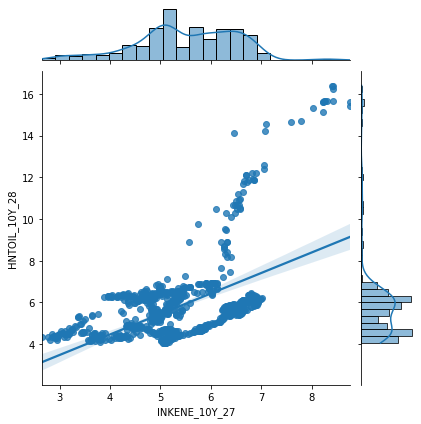

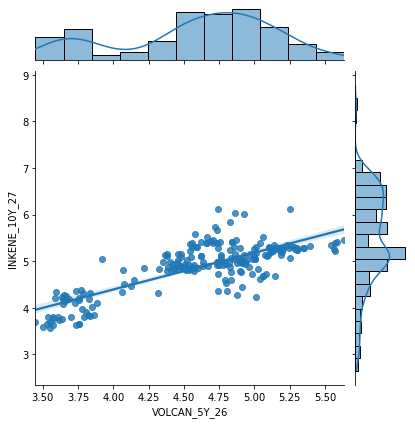

In [58]:
sns.jointplot(YTW_extra[bono],YTW_extra[first],kind='reg')
sns.jointplot(YTW_extra[last],YTW_extra[bono],kind='reg')
plt.show()

# Procesamiento:

In [35]:
PAIS = ['PE']
RATING = ['BBB','BBB+','BBB-','BB+','BB','BB-','B+','B','B-']
DUR = '3 <= DUR_ADJ_MID <= 10'
filtro, isin_list, codigo = filtrado(filtros, PAIS, RATING, DUR)
filtro

,Isin,SECURITY_NAME,CNTRY_OF_RISK,BB_COMPOSITE,ISSUE_DT,MATURITY,CALLABLE,NXT_CALL_DT,CPN,DUR_ADJ_MID,YLD_CNV_LAST,PX_MID,Codigo,Unnamed: 13
12,AR783041 Corp,PERLNG 5 3/8 03/22/30,PE,B,22/03/2018,22/03/2030,N,NaN,5.375,4.472965,9.007636,84.4825,PERLNG_12Y_30,NaN
22,AS799812 Corp,HNTOIL 6 3/8 06/01/28,PE,BB+,1/06/2018,1/06/2028,N,NaN,6.375,3.723181,6.888247,98.0265,HNTOIL_10Y_28,NaN
26,BN935824 Corp,VOLCAN 4 3/8 02/11/26,PE,BB-,11/02/2021,11/02/2026,Y,11/02/2023,4.375,3.809697,4.820198,98.2925,VOLCAN_5Y_26,NaN
76,BQ642890 Corp,BUENAV 5 1/2 07/23/26,PE,BB-,23/07/2021,23/07/2026,Y,23/07/2023,5.500,4.046883,5.582572,99.6505,BUENAV_5Y_26,NaN
103,AN955120 Corp,PETRPE 4 3/4 06/19/32,PE,BBB-,19/06/2017,19/06/2032,N,NaN,4.750,8.230692,4.071255,105.7915,PETRPE_15Y_32,NaN
124,BK277053 Corp,BCP 3 1/8 07/01/30,PE,BBB-,1/07/2020,1/07/2030,Y,1/07/2025,3.125,3.393939,3.367622,99.1705,BCP_10Y_30,NaN
126,AP843541 Corp,INKENE 5 7/8 11/09/27,PE,BB-,9/11/2017,9/11/2027,Y,9/11/2022,5.875,3.460266,4.961185,103.3055,INKENE_10Y_27,NaN
130,AP154964 Corp,FENIPE 4.317 09/20/27,PE,BBB-,20/09/2017,20/09/2027,Y,20/06/2027,4.317,3.841710,3.756199,102.1835,FENIPE_10Y_27,NaN
158,AO701606 Corp,KALLPA 4 1/8 08/16/27,PE,BBB-,16/08/2017,16/08/2027,Y,16/05/2027,4.125,4.895917,3.301302,104.1110,KALLPA_10Y_27,NaN
161,BQ734496 Corp,SMIPET 3 1/2 08/02/28,PE,BB+,2/08/2021,2/08/2028,Y,2/08/2024,3.500,5.906599,3.606041,99.3655,SMIPET_7Y_28,NaN


In [36]:
Criterio = 'YLD_CNV_MID'
Start_date = '20180101'
End_date = '20221101'
corps = bloomberg(isin_list,codigo,Criterio,Start_date,End_date)
corps.columns

Index(['PERLNG_12Y_30', 'HNTOIL_10Y_28', 'VOLCAN_5Y_26', 'BUENAV_5Y_26',
       'KALLPA_10Y_27', 'SMIPET_7Y_28', 'KALLPA_10Y_26', 'TGPERU_15Y_28',
       'BCP_11Y_31', 'LIMAMT_19Y_34', 'BINTPE_10Y_30', 'COFIDE_10Y_25'],
      dtype='object')

In [39]:
Spreads = spreads(corps)
Periodo = 20
Zscore20 = zscore(Spreads,20)

In [40]:
zeta,spread,media,desvi = tabla_zscore(corps,20)
zeta

,PERLNG_12Y_30,HNTOIL_10Y_28,VOLCAN_5Y_26,BUENAV_5Y_26,KALLPA_10Y_27,SMIPET_7Y_28,KALLPA_10Y_26,TGPERU_15Y_28,BCP_11Y_31,LIMAMT_19Y_34,BINTPE_10Y_30,COFIDE_10Y_25
Venta\Compra,,,,,,,,,,,,
PERLNG_12Y_30,nan,0.39,0.78,1.16,0.49,-0.70,0.01,0.63,1.27,1.36,nan,0.78
HNTOIL_10Y_28,-0.39,nan,-0.16,-0.01,-0.31,-0.54,-0.37,-0.27,-0.03,-0.00,nan,-0.28
VOLCAN_5Y_26,-0.78,0.16,nan,0.70,-0.59,-1.29,-1.19,-0.39,0.50,0.68,nan,-0.55
BUENAV_5Y_26,-1.16,0.01,-0.70,nan,-1.23,-1.25,-1.34,-0.80,-0.07,0.04,nan,-1.00
KALLPA_10Y_27,-0.49,0.31,0.59,1.23,nan,-0.85,-0.50,0.17,1.24,1.29,nan,0.12
SMIPET_7Y_28,0.70,0.54,1.29,1.25,0.85,nan,0.87,0.98,1.42,1.21,nan,0.95
KALLPA_10Y_26,-0.01,0.37,1.19,1.34,0.50,-0.87,nan,0.60,1.62,1.27,nan,0.50
TGPERU_15Y_28,-0.63,0.27,0.39,0.80,-0.17,-0.98,-0.60,nan,0.97,1.08,nan,-0.08
BCP_11Y_31,-1.27,0.03,-0.50,0.07,-1.24,-1.42,-1.62,-0.97,nan,0.09,nan,-1.29


In [34]:
bono = 'SMIPET_7Y_28'
ranki, first, last = rank_spread(zeta,spread,media,bono)
ranki

,Z-Score,Spread Actual,Compresión Potencial
Venta,,,
HNTOIL_10Y_28,-0.58,-2.9,-0.21
PERLNG_12Y_30,-0.72,-5.29,-0.1
INKENE_10Y_27,-1.05,-1.33,-0.27
BUENAV_5Y_26,-1.28,-2.06,-0.2
INRCON_7Y_28,-1.34,0.08,-0.17
VOLCAN_5Y_26,-1.49,-1.28,-0.18
AUNASA_5Y_25,-1.85,-1.85,-0.27


In [ ]:
mejor = corps[[bono,first]].dropna()
mejor.iplot(kind='spread',title='Top Zscore')

In [ ]:
mejor, par_a = panda_mejor_peor(Spreads,bono,first,20)
mejor[[par_a,'Movav','+2std','-2std']].iplot()

In [ ]:
corte = corps[[last,bono]].dropna()
corte.iplot(kind='spread',title='Last Zscore')

In [ ]:
mejor, par_b = panda_mejor_peor(Spreads,last,bono,20)
mejor[[par_b,'Movav','+2std','-2std']].iplot()

# Aplicativo StreamLit